# Siamese Networks


## Introduction

Let's start with what are siamese networks? 

A siamese neural network consists of same network typically a CNN, which accept distinct inputs and generates embeddings as output. We add different loss function to encourage brining similar images together and different images apart in embedding space. Siamese NNs are popular among tasks that involve finding similarity or a relationship between two comparable things. We apply different loss functions to encourage such behaviour. Siamese networks typically share the same base network (CNN) which can be used as embedding extractor i.e. 3 inputs for triplet loss which will generate 3 outputs of embedding size of 128 or 2 inputs for contrastive loss will generate 2 outputs of embedding size of 128. 


---

## Types of Siamese Networks

Siamese Networks comes in two flavours: using triplet loss and another using contrastive loss. Let's visit each of them.


- **Triplets Loss**

Triplets, are basically 3 images (yeah, no brainer!) which are anchor, positive and negative. What are these? **The anchor is any example from dataset. The positive is any example other than anchor belonging to same class as anchor.** And finally, **negative is any example belonging to class other than the anchor. In triplet loss, what we do lot's of triplets.** There are different ways to sample or known as mining triplets and this is what makes and breaks triplet loss approach. For some distance on the embedding space d, the loss of a triplet (a,p,n) is

$$\mathcal{L} = max(d(a, p) - d(a, n) + margin, 0)$$


There are different such as easy triplets, semi-hard triplets, hard triplets. **Easy triplets are triplets which as loss 0**, because $$d(a, p) + margin < d(a,n)$$ **Semi-hard triplets are triplets where the negative is not closer to the anchor than the positive, but which still have positive loss,** i.e. $$d(a, p) < d(a, n) < d(a, p) + margin$$ **Hard Triplets are triplets where the negative is closer to the anchor than the positive**, i.e. $$d(a,n) < d(a,p)$$


In the original Facenet paper, they pick a random semi-hard negative for every pair of anchor and positive, and train on these triplets and also according to paper, selecting the hardest negatives can in practice lead to badlocal minima early on in training. "Additionally, the selected triplets can be considered moderate triplets, since they are the hardest within a small subset of the data, which is exactly what is best for learning with the triplet loss", according to [this](https://arxiv.org/abs/1703.07737) paper. So, there is no thumb rule but starting with semi-hard yields good results and poor with easy.


Now having decided what strategy to use for batching minings, comes the challenge of training on batch of triplets. There are two way in which batches of triplets can be trained : (i) **Offline triplet mining, where we produce triplets offline, at the beginning of each epoch for instance.** We compute all the embeddings on the training set, and then only select hard or semi-hard triplets. We can then train one epoch on these triplets. (ii) **Online triplet mining, where we compute useful triplets on the fly, for each batch of inputs.** This technique gives you more triplets for a single batch of inputs, and doesn’t require any offline mining. It is therefore much more efficient. Details of each method are described in [this](https://arxiv.org/abs/1703.07737) paper.

 The motivation is that the triplet loss encourages all examples belonging to same class i.e. of one  identity to be projected onto a single point in the embedding  space.


- **Contrastive Loss**

This the simplest among the two. Here, we sample two pairs of images, one **positive** and another **negative** or also known as, **similar** and **different**  pairs unlike above where we sample triplets. The two pairs i.e. **similar which contains any two images belonging to similar class** and **different where any two images belong to different class.** So, we create a lot many such similar and different pairs and pass it to any CNN architecture without the head(classification layer) and use the dimension of penultimate layer or add any number of linear layers  to obtain embeddings of size, say 128. Different name for loss suggests, we are not using our typical classification loss such as NLL or cross entropy for classification as there is no classification layer. So, how can we train our model (as in, what to backpropogate)? The answer is contrastive loss. **Contrastive Loss is a distance-based loss where such losses try to ensure that semantically similar examples are embedded close together.** This is what makes them special for our case, where we want similar images to be present closer in the embedding space and push different pairs away. We can also train by adding cross entropy as loss function with labels as 0 for similar images and 1 for different images. To learn more about this loss function, please read the paper linked below.


---

## Further Readings

[Signature Verification using a "Siamese" Time Delay Neural Network ](https://papers.nips.cc/paper/769-signature-verification-using-a-siamese-time-delay-neural-network.pdf)

[Siamese Neural Networks for One-shot Image Recognition](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

[Facenet paper introducing Triplets](https://arxiv.org/abs/1503.03832)

[Contrastive Loss paper](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

[In defense of Triplet Loss for Person Re-identification](https://arxiv.org/abs/1703.07737)

[Andrew Ng's Triplet Loss Lecture](https://www.coursera.org/learn/convolutional-neural-networks/lecture/HuUtN/triplet-loss)

[Triplet Loss and Online Triplet Mining in TensorFlow](https://omoindrot.github.io/triplet-loss)

---

## Experiements

Here we will start small with everyone's favourite dataset MNIST. (Yay!!) We will implement both triplet loss and contrastive loss siamese networks on MNIST and obtain the projections using t-SNE on embeddings trained on siamese model to see how different cluster are formed and how far are they separated indicating they have been successful in perform their task.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Siamese/Siamese_MNIST_keras.ipynb)


# Keras

In [0]:
import keras
import random
import tensorflow as tf
import numpy as np
import time
import keras.backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Lambda, Layer, Input, concatenate, Concatenate
from functools import partial, update_wrapper
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(42)

In [0]:
(train_X, train_Y), (val_X, val_Y) = mnist.load_data()
print ('Training shape:', train_X.shape, train_Y.shape)
print ('Validation shape:', val_X.shape, val_Y.shape)

Training shape: (60000, 28, 28) (60000,)
Validation shape: (10000, 28, 28) (10000,)


In [0]:
img_size = 28
input_shape = (28, 28, 1)
num_classes = 10

In [0]:
train_x = train_X.astype('float32')
val_x = val_X.astype('float32')
train_x /= 255
val_x /= 255

train_y = to_categorical(train_Y, num_classes=num_classes)
val_y = to_categorical(val_Y, num_classes=num_classes)
print ('Training shape:', train_x.shape, train_y.shape)
print ('Validation shape:', val_x.shape, val_y.shape)

Training shape: (60000, 28, 28) (60000, 10)
Validation shape: (10000, 28, 28) (10000, 10)


In [0]:
def siamese_network():
    
    inp = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)(inp)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(x)
    
    return Model(inputs=inp, outputs=norm_layer)

In [0]:
siamese_model = siamese_network()
siamese_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
__________

## Method - 1 (Triplet Loss)

### FInd hard positives and negatives using embedding distance

In [0]:
num_images_by_class = []

for i in range(len(np.unique(train_Y))):
    
    num_images_by_class.append(len(train_Y[train_Y == i]))
    
num_images_by_class = np.array(num_images_by_class)

In [0]:
#Form batches by randomly sampling P classes (person identities), 
#and then randomly sampling K images of each class (person)
#resulting in a batch of PK images.
#Choose B, P, and K in such a way that 3B is close to PK
#P = 42, K = 4, B = 96

#For each sample a in the batch, we can select the hardest positive 
#and the hardest negative samples within the batch when forming the triplets 
#for computing the loss, which we call Batch Hard

#The selected triplets can be considered moderate triplets, 
#since they are the hardest within a small subset of the data, 
#which is exactly what is best for learning with the triplet loss

class BatchHard:
    
    def __init__(self, batch_size, P):
        self.P = P
        self.batch_size = batch_size
        
    def get_batch(self):
        
        #randomly sample P classes based on probability distribution of classes
        P_classes = np.random.choice(np.arange(train_y.shape[1]), p=num_images_by_class/num_images_by_class.sum(), size=self.P)
        #print (P_classes)
        batch_samples = []
        anchors = []
        positives = []
        negatives = []
        j = 0        

        #for each class in P
        for i in P_classes:
            #find the instances of same class
            lbl_index = np.where(train_Y == i)
            #sample 1 images of each classes
            random_index = np.random.choice(lbl_index[0], size=1)
            #batch of P images
            batch_samples.append(train_X[random_index])
            j += 1

        batch_samples = np.squeeze(batch_samples)
        batch = batch_samples.reshape((-1, 28, 28, 1))

        #pass the batch of P images to siamese network to predict embeddings for each image
        pred_batch_samples = siamese_model.predict(batch)

        #find all hardest positive and hard negative for each a in batch
        for i in range(len(batch_samples)):
            #print ('Current:', P_classes[i])
            similar_class = np.where(P_classes == P_classes[i])[0]
            diff_class = np.where(P_classes != P_classes[i])[0]
            #print ('Similar Class:', similar_class)
            #print ('Different Class:', diff_class)

            a = pred_batch_samples[i]
            anchors.append(batch_samples[i])
            #print ('Anchor predicted embedding:', a, a.shape)

            # find hard positive
            positive_dist = []
            #print ('Positive predicted embedding:')
            for sim_index in similar_class:
                #print (pred_batch_samples[sim_index], pred_batch_samples[sim_index].shape)
                positive_dist.append(np.linalg.norm(a-pred_batch_samples[sim_index]))
            #print ('Positive:', positive_dist, similar_class[np.argmax(np.array(positive_dist))])
            positives.append(batch_samples[similar_class[np.argmax(np.array(positive_dist))]])

            # find hard negative
            negative_dist = []
            for diff_index in diff_class:
                negative_dist.append(np.linalg.norm(a-pred_batch_samples[diff_index]))
            #print ('Negative:', negative_dist, diff_class[np.argmin(np.array(negative_dist))])
            negatives.append(batch_samples[diff_class[np.argmin(np.array(negative_dist))]])
        anchors = np.array(anchors)
        anchors = anchors.reshape(-1, anchors.shape[-2], anchors.shape[-1])
        positives = np.array(positives)
        positives = positives.reshape(-1, positives.shape[-2], positives.shape[-1])
        negatives = np.array(negatives)
        negatives = negatives.reshape(-1, negatives.shape[-2], negatives.shape[-1])
        self.triplets = [np.expand_dims(anchors, axis=-1), np.expand_dims(positives, axis=-1), np.expand_dims(negatives, axis=-1)]

        return np.array(self.triplets)

    def show_samples(self, anchors, positives, negatives):
        rand_index = random.sample(list(np.arange(anchors.shape[0])), 4) 
        fig, ax = plt.subplots(4, 3)
        ax[0][0].imshow(np.squeeze(anchors[rand_index[0]]))
        ax[0][1].imshow(np.squeeze(positives[rand_index[0]]))
        ax[0][2].imshow(np.squeeze(negatives[rand_index[0]]))
        ax[1][0].imshow(np.squeeze(anchors[rand_index[1]]))
        ax[1][1].imshow(np.squeeze(positives[rand_index[1]]))
        ax[1][2].imshow(np.squeeze(negatives[rand_index[1]]))
        ax[2][0].imshow(np.squeeze(anchors[rand_index[2]]))
        ax[2][1].imshow(np.squeeze(positives[rand_index[2]]))
        ax[2][2].imshow(np.squeeze(negatives[rand_index[2]]))
        ax[3][0].imshow(np.squeeze(anchors[rand_index[3]]))
        ax[3][1].imshow(np.squeeze(positives[rand_index[3]]))
        ax[3][2].imshow(np.squeeze(negatives[rand_index[3]]))
        plt.show()
    
#     # data generator for triplets
#     def batch_generator(self):
#         i = 0
#         while True:
#             a_embed = np.array(self.triplets[0][i:i+self.batch_size])
#             p_embed = np.array(self.triplets[1][i:i+self.batch_size])
#             n_embed = np.array(self.triplets[2][i:i+self.batch_size])
#             print (np.array(self.triplets).shape)
#             print (i, i+self.batch_size)
#             print (a_embed.shape, p_embed.shape, n_embed.shape)
#             i += self.batch_size

#             yield (np.concatenate([a_embed, p_embed, n_embed], axis=0), np.zeros(3*self.batch_size))
            
#     # return data generator for triplets
#     def get_generator(self):
#         gen = self.batch_generator()
#         return gen

In [0]:
class TripletLossLayer(Layer):
    
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=1)
        n_dist = K.sum(K.square(a-n), axis=1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [0]:
a_inp = Input(shape=(28, 28, 1))
p_inp = Input(shape=(28, 28, 1))
n_inp = Input(shape=(28, 28, 1))

In [0]:
a_embed = siamese_model(a_inp)
p_embed = siamese_model(p_inp)
n_embed = siamese_model(n_inp)

In [0]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([a_embed, p_embed, n_embed])

# Model that can be trained with anchor, positive negative images
model = Model(inputs=[a_inp, p_inp, n_inp], outputs=triplet_loss_layer)

In [0]:
model.summary()
model.compile(loss=None, optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          1198592     input_7[0][0]                    
                                                                 input_8[0][0]                    
          

In [0]:
batch_size = 60
P = 20000

In [0]:
batches = BatchHard(batch_size, P)
triplets = batches.get_batch()
a = np.array(triplets[0])
p = np.array(triplets[1])
n = np.array(triplets[2])

In [0]:
model.fit([a, p, n], None, epochs=50, batch_size=batch_size, verbose=1)

Epoch 1/50
20000/20000 [==============================] - 4s 224us/step - loss: 5.3933
Epoch 2/50
20000/20000 [==============================] - 4s 195us/step - loss: 1.0430
Epoch 3/50
20000/20000 [==============================] - 4s 188us/step - loss: 0.5894
Epoch 4/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.3798
Epoch 5/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.2910
Epoch 6/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1995
Epoch 7/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1708
Epoch 8/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1668
Epoch 9/50
20000/20000 [==============================] - 4s 191us/step - loss: 0.1227
Epoch 10/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1190
Epoch 11/50
20000/20000 [==============================] - 4s 189us/step - loss: 0.1274
Epoch 12/50
20000/20000 [================

#### t-SNE visualization

In [0]:
import random
from keras.models import Model
from keras.preprocessing import image
np.random.seed(42)

arr = train_X[:512]
lbl = train_Y[:512]
print (arr.shape, lbl.shape)

(512, 28, 28) (512,)


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          1198592     input_7[0][0]                    
                                                                 input_8[0][0]                    
          

In [0]:
model.layers[3].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
__________

In [0]:
model.save_weights('weights.h5')

In [0]:
tmp_model = Model(a_inp, a_embed)
tmp_model.summary()
tmp_model.load_weights('weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_3 (Model)              (None, 128)               1198592   
Total params: 1,198,592
Trainable params: 1,198,592
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train_trm = tmp_model.predict(train_x.reshape(-1,28,28,1))

Classifier_input = Input((128,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm, train_y, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 5s 83us/step - loss: 2.2380 - acc: 0.2377
Epoch 2/10
60000/60000 [==============================] - 5s 78us/step - loss: 2.1292 - acc: 0.4381
Epoch 3/10
60000/60000 [==============================] - 5s 78us/step - loss: 2.0372 - acc: 0.5031
Epoch 4/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.9579 - acc: 0.5386
Epoch 5/10
60000/60000 [==============================] - 5s 77us/step - loss: 1.8887 - acc: 0.5583
Epoch 6/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.8280 - acc: 0.5679
Epoch 7/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.7739 - acc: 0.5774
Epoch 8/10
60000/60000 [==============================] - 5s 79us/step - loss: 1.7260 - acc: 0.5857
Epoch 9/10
60000/60000 [==============================] - 5s 90us/step - loss: 1.6829 - acc: 0.5913
Epoch 10/10
60000/60000 [==============================] - 5s 88us/step - loss: 1.6439 - acc: 0.5978

In [0]:
img_arr = arr.reshape(*arr.shape, 1)
img_arr.shape

(512, 28, 28, 1)

In [0]:
preds = tmp_model.predict(img_arr, batch_size=50)
print (preds.shape)

(512, 128)


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
x_train_flat = train_x.reshape(-1,784)

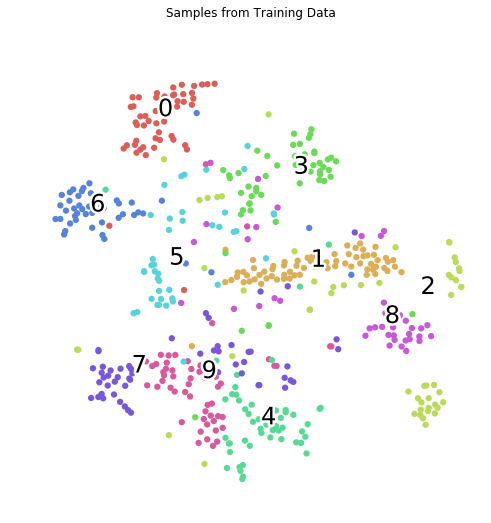

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, train_Y[:512], "Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(lbl)
l[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [0]:
preds_trans = TSNE().fit_transform(preds)

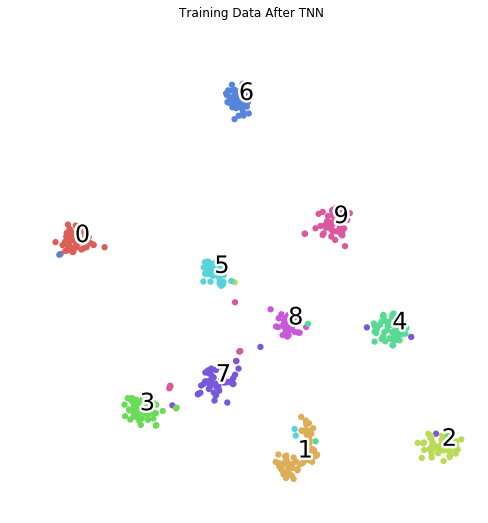

In [0]:
scatter(preds_trans, train_Y[:512], "Training Data After TNN")

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-6.717429,8.386817,5.0
1,-28.196423,15.490483,0.0
2,16.823631,1.653309,4.0
3,2.417643,-22.085928,1.0
4,10.743126,19.940912,9.0


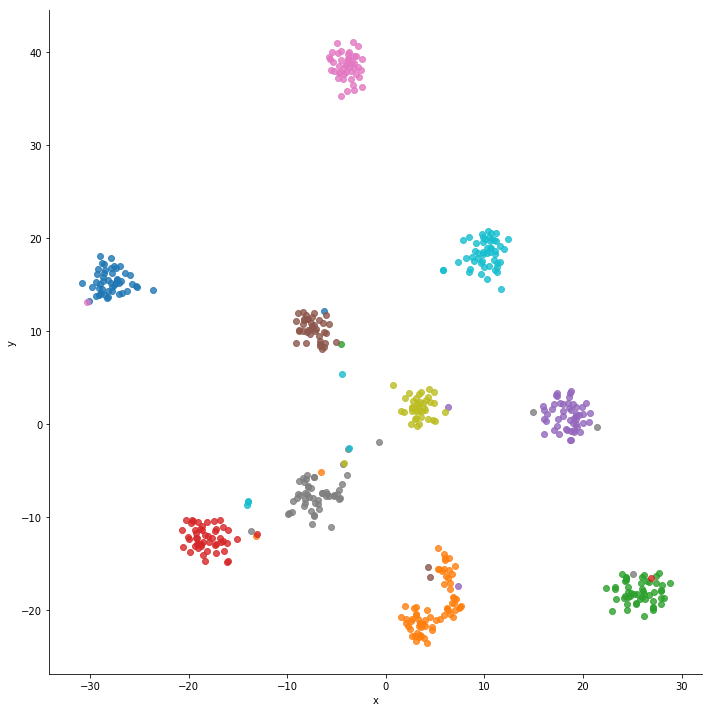

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)

### Finding hard positives and negatives using image distance

In [0]:
num_images_by_class = []

for i in range(len(np.unique(train_Y))):
    
    num_images_by_class.append(len(train_Y[train_Y == i]))
    
num_images_by_class = np.array(num_images_by_class)

In [0]:
#Form batches by randomly sampling P classes (person identities), 
#and then randomly sampling K images of each class (person)
#resulting in a batch of PK images.
#Choose B, P, and K in such a way that 3B is close to PK
#P = 42, K = 4, B = 96

#For each sample a in the batch, we can select the hardest positive 
#and the hardest negative samples within the batch when forming the triplets 
#for computing the loss, which we call Batch Hard

#The selected triplets can be considered moderate triplets, 
#since they are the hardest within a small subset of the data, 
#which is exactly what is best for learning with the triplet loss

class BatchHard:
    
    def __init__(self, batch_size, P, N):
        self.P = P
        self.N = N
        self.batch_size = batch_size
        
    def get_batch(self):
        
        #randomly sample P classes based on probability distribution of classes
        P_classes = np.random.choice(np.arange(train_y.shape[1]), p=num_images_by_class/num_images_by_class.sum(), size=self.P)
        batch_samples = [[] for _ in range(self.P)]
        anchors = [[] for _ in range(self.P)]
        positives = [[] for _ in range(self.P)]
        negatives = [[] for _ in range(self.P)]
        j = 0        
        
        #for each class in P
        for i in P_classes:
            #find the instances of same class
            lbl_index = np.where(train_Y == i)
            #sample K images of each classes
            random_index = np.random.choice(lbl_index[0], size=self.N)
            #batch of PK images
            batch_samples[j].append(train_X[random_index])
            j += 1

        batch_samples = np.squeeze(batch_samples)
        
        #find all hardest positive and hard negative for each a in batch
        for i in range(len(batch_samples)):
            similar_class = np.where(P_classes == P_classes[i])[0]
            
            j = 0
            while(j < self.N):
                a = batch_samples[i][j]
                anchors[i].append(a)
                
                #find hard positive
                positive_dist = [[] for _ in range(self.P)]
                for p in range(self.P):
                    if p not in similar_class :
                        positive_dist[p].append([0]*self.N)           
                    else:
                        for k in range(self.N):
                            positive_dist[p].append(np.linalg.norm(a-batch_samples[p][k]))
                    positive_dist[p] = np.squeeze(np.array(positive_dist[p]))   
                positives[i].append(batch_samples[np.argmax(np.array(positive_dist)) // self.N][np.argmax(np.array(positive_dist)) % self.N])
                
                #find hard negative             
                negative_dist = [[] for _ in range(self.P)]
                for p in range(self.P):
                    if p in similar_class :
                        negative_dist[p].append([np.nan]*self.N)           
                    else:
                        for k in range(self.N):
                            negative_dist[p].append(np.linalg.norm(a-batch_samples[p][k]))
                    negative_dist[p] = np.squeeze(np.array(negative_dist[p]))                

                negatives[i].append(batch_samples[np.nanargmin(np.array(negative_dist)) // self.N][np.nanargmin(np.array(negative_dist)) % self.N])
                j+=1
 
        anchors = np.array(anchors)
        anchors = anchors.reshape(-1, anchors.shape[-2], anchors.shape[-1])
        positives = np.array(positives)
        positives = positives.reshape(-1, positives.shape[-2], positives.shape[-1])
        negatives = np.array(negatives)
        negatives = negatives.reshape(-1, negatives.shape[-2], negatives.shape[-1])
        self.triplets = [np.expand_dims(anchors, axis=-1), np.expand_dims(positives, axis=-1), np.expand_dims(negatives, axis=-1)]
        
        return np.array(self.triplets)
 
    def show_samples(self, anchors, positives, negatives):
        print (anchors.shape, anchors[0].shape, anchors[0][0].shape)
        fig, ax = plt.subplots(4, 3)
        ax[0][0].imshow(np.squeeze(anchors[0]))
        ax[0][1].imshow(np.squeeze(positives[0]))
        ax[0][2].imshow(np.squeeze(negatives[0]))
        ax[1][0].imshow(np.squeeze(anchors[1]))
        ax[1][1].imshow(np.squeeze(positives[1]))
        ax[1][2].imshow(np.squeeze(negatives[1]))
        ax[2][0].imshow(np.squeeze(anchors[2]))
        ax[2][1].imshow(np.squeeze(positives[2]))
        ax[2][2].imshow(np.squeeze(negatives[2]))
        ax[3][0].imshow(np.squeeze(anchors[3]))
        ax[3][1].imshow(np.squeeze(positives[3]))
        ax[3][2].imshow(np.squeeze(negatives[3]))
        plt.show()

#     # data generator for triplets
#     def batch_generator(self):
#         i = 0
#         while True:
#             a_embed = np.array(self.triplets[0][i:i+self.batch_size])
#             p_embed = np.array(self.triplets[1][i:i+self.batch_size])
#             n_embed = np.array(self.triplets[2][i:i+self.batch_size])
#             print (i, i+self.batch_size)
#             print (a_embed.shape, p_embed.shape, n_embed.shape)
#             print (a_embed)
#             i += self.batch_size

#             yield [a_embed, p_embed, n_embed], None
            
#     # return data generator for triplets
#     def get_generator(self):
#         gen = self.batch_generator()
#         return gen       

In [0]:
class TripletLossLayer(Layer):
    
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=1)
        n_dist = K.sum(K.square(a-n), axis=1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [0]:
a_inp = Input(shape=(28, 28, 1))
p_inp = Input(shape=(28, 28, 1))
n_inp = Input(shape=(28, 28, 1))

In [0]:
a_embed = siamese_model(a_inp)
p_embed = siamese_model(p_inp)
n_embed = siamese_model(n_inp)

In [0]:
# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([a_embed, p_embed, n_embed])

# Model that can be trained with anchor, positive negative images
model = Model(inputs=[a_inp, p_inp, n_inp], outputs=triplet_loss_layer)

In [0]:
model.summary()
model.compile(loss=None, optimizer='adam')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 128)          1198592     input_13[0][0]                   
                                                                 input_14[0][0]                   
          

In [0]:
batch_size = 32
epochs = 0
P = 500
N = 40
batches = BatchHard(batch_size, P, N)
num_samples = P*N

In [0]:
triplets = batches.get_batch()
a = np.array(triplets[0])
p = np.array(triplets[1])
n = np.array(triplets[2])

In [0]:
model.fit([a, p, n], None, epochs=50, batch_size=batch_size, verbose=1)

Epoch 1/50
20000/20000 [==============================] - 6s 285us/step - loss: 1.1472
Epoch 2/50
20000/20000 [==============================] - 5s 256us/step - loss: 0.3572
Epoch 3/50
20000/20000 [==============================] - 5s 256us/step - loss: 0.2159
Epoch 4/50
20000/20000 [==============================] - 5s 255us/step - loss: 0.1425
Epoch 5/50
20000/20000 [==============================] - 5s 254us/step - loss: 0.0870
Epoch 6/50
20000/20000 [==============================] - 5s 254us/step - loss: 0.0732
Epoch 7/50
20000/20000 [==============================] - 5s 254us/step - loss: 0.0639
Epoch 8/50
20000/20000 [==============================] - 5s 253us/step - loss: 0.0618
Epoch 9/50
20000/20000 [==============================] - 5s 265us/step - loss: 0.0430
Epoch 10/50
20000/20000 [==============================] - 5s 271us/step - loss: 0.0384
Epoch 11/50
20000/20000 [==============================] - 5s 255us/step - loss: 0.0436
Epoch 12/50
20000/20000 [================

#### t-SNE visualization

In [0]:
import random
from keras.models import Model
from keras.preprocessing import image
np.random.seed(42)

arr = train_X[:512]
lbl = train_Y[:512]
print (arr.shape, lbl.shape)

(512, 28, 28) (512,)


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_10 (Model)                (None, 128)          1198592     input_13[0][0]                   
                                                                 input_14[0][0]                   
          

In [0]:
model.layers[3].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1179776   
__________

In [0]:
model.save_weights('weights.h5')

In [0]:
tmp_model = Model(a_inp, a_embed)
tmp_model.summary()
tmp_model.load_weights('weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
model_10 (Model)             (None, 128)               1198592   
Total params: 1,198,592
Trainable params: 1,198,592
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train_trm = tmp_model.predict(train_x.reshape(-1,28,28,1))

Classifier_input = Input((128,))
Classifier_output = Dense(10, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Classifier_model.fit(X_train_trm, train_y, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 5s 78us/step - loss: 1.6081 - acc: 0.8052
Epoch 2/10
60000/60000 [==============================] - 4s 73us/step - loss: 0.8593 - acc: 0.9072
Epoch 3/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.5675 - acc: 0.9113
Epoch 4/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.4340 - acc: 0.9136
Epoch 5/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.3649 - acc: 0.9162
Epoch 6/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.3258 - acc: 0.9177
Epoch 7/10
60000/60000 [==============================] - 5s 88us/step - loss: 0.3019 - acc: 0.9194
Epoch 8/10
60000/60000 [==============================] - 5s 81us/step - loss: 0.2860 - acc: 0.9207
Epoch 9/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.2750 - acc: 0.9218
Epoch 10/10
60000/60000 [==============================] - 4s 72us/step - loss: 0.2669 - acc: 0.9227

In [0]:
img_arr = arr.reshape(*arr.shape, 1)
img_arr.shape

(512, 28, 28, 1)

In [0]:
preds = tmp_model.predict(img_arr, batch_size=50)
print (preds.shape)

(512, 128)


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
x_train_flat = train_x.reshape(-1,784)

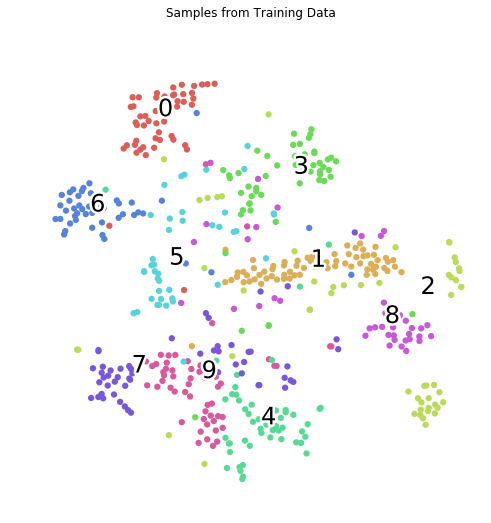

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, train_Y[:512], "Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(lbl)
l[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [0]:
preds_trans = TSNE().fit_transform(preds)

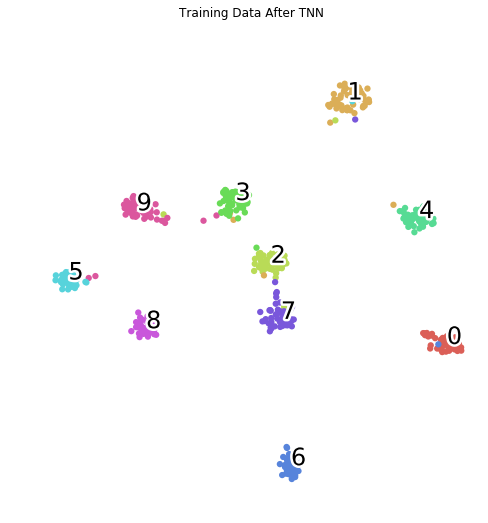

In [0]:
scatter(preds_trans, train_Y[:512], "Training Data After TNN")

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-32.830582,-3.567229,5.0
1,27.243023,-15.246427,0.0
2,20.956648,9.557454,4.0
3,11.588186,30.425179,1.0
4,-20.081406,9.931993,9.0


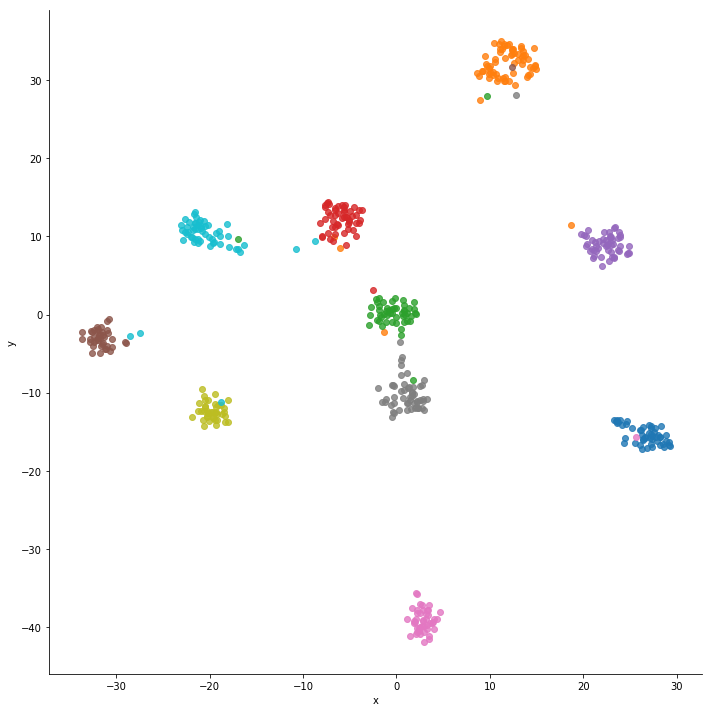

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)

## Method - 2 (Contrastive Loss)

In [0]:
num_images_by_class = []

for i in range(len(np.unique(train_Y))):
    
    num_images_by_class.append(len(train_Y[train_Y == i]))
    
num_images_by_class = np.array(num_images_by_class)

In [0]:
class SampleBatch:
    
    def __init__(self, num_pairs, batch_size):
        self.batch_size = batch_size
        self.P = num_pairs
        
    def get_batch(self):
        P_classes = np.random.choice(np.arange(train_y.shape[1]), p=num_images_by_class/num_images_by_class.sum(), size=self.P)

        batch_samples = [[] for _ in range(self.P)]
        pairs1 = [[] for _ in range(self.P)]
        pairs2 = [[] for _ in range(self.P)]


        for i in range(len(P_classes)):
            lbl = P_classes[i]

            same_class_index = np.where(train_Y == lbl)[0]
            diff_class_index = np.where(train_Y != lbl)[0]

            pos_index = random.sample(list(same_class_index), k=3)
            neg_index = random.sample(list(diff_class_index), k=1)

            pairs1[i].append(np.expand_dims(np.array(train_x[pos_index[0]]), axis=-1))
            pairs1[i].append(np.expand_dims(np.array(train_x[pos_index[1]]), axis=-1))
            pairs1[i].append(1)
            pairs2[i].append(np.expand_dims(np.array(train_x[pos_index[2]]), axis=-1))
            pairs2[i].append(np.expand_dims(np.array(train_x[neg_index[0]]), axis=-1))
            pairs2[i].append(0)
            pairs1[i] = np.array(pairs1[i])
            pairs2[i] = np.array(pairs2[i])
            
        self.duplets = np.vstack([pairs1, pairs2])
        
        return self.duplets

In [0]:
img1 = Input(shape=(28, 28, 1))
img2 = Input(shape=(28, 28, 1))

In [0]:
siamese_model = siamese_network()
siamese_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36868     
__________

In [0]:
img1_embed = siamese_model(img1)
img2_embed = siamese_model(img2)

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [0]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [0]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([img1_embed, img2_embed])

# Model that can be trained with anchor, positive negative images
model = Model(inputs=[img1, img2], outputs=distance)

In [0]:
model.summary()
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[accuracy])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 4)            55684       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[1][0]                    
          

In [0]:
batch_size = 128
epochs = 10
num_pairs = 10000
batches = SampleBatch(num_pairs, batch_size)
trn_pairs = batches.get_batch()
num_samples = num_pairs

trn_pairs1 = np.array(list(trn_pairs[:, 0])).reshape((2*num_pairs, 28, 28, 1))
trn_pairs2 = np.array(list(trn_pairs[:, 1])).reshape((2*num_pairs, 28, 28, 1))
trn_y = trn_pairs[:, 2]

In [0]:
model.fit([trn_pairs1, trn_pairs2], trn_y,
          batch_size=batch_size,
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
20000/20000 [==============================] - 5s 238us/step - loss: 0.1412 - accuracy: 0.8034
Epoch 2/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.0810 - accuracy: 0.9120
Epoch 3/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.0621 - accuracy: 0.9370
Epoch 4/10
20000/20000 [==============================] - 2s 100us/step - loss: 0.0558 - accuracy: 0.9453
Epoch 5/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.0500 - accuracy: 0.9551
Epoch 6/10
20000/20000 [==============================] - 2s 100us/step - loss: 0.0464 - accuracy: 0.9627
Epoch 7/10
20000/20000 [==============================] - 2s 101us/step - loss: 0.0460 - accuracy: 0.9644
Epoch 8/10
20000/20000 [==============================] - 2s 99us/step - loss: 0.0484 - accuracy: 0.9625
Epoch 9/10
20000/20000 [==============================] - 2s 100us/step - loss: 0.0486 - accuracy: 0.9605
Ep

### t-SNE visualization

In [0]:
import random
from keras.models import Model
from keras.preprocessing import image
np.random.seed(42)

arr = train_X[:512]
lbl = train_Y[:512]
print (arr.shape, lbl.shape)

(512, 28, 28) (512,)


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 4)            55684       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[1][0]                    
          

In [0]:
model.layers[2].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36868     
__________

In [0]:
model.save_weights('weights.h5')

In [0]:
tmp_model = Model(img1, img1_embed)
tmp_model.summary()
tmp_model.load_weights('weights.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_2 (Model)              (None, 4)                 55684     
Total params: 55,684
Trainable params: 55,684
Non-trainable params: 0
_________________________________________________________________


In [0]:
img_arr = arr.reshape(*arr.shape, 1)
img_arr.shape

(512, 28, 28, 1)

In [0]:
preds = tmp_model.predict(img_arr, batch_size=50)
print (preds.shape)

(512, 4)


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [0]:
x_train_flat = train_x.reshape(-1,784)

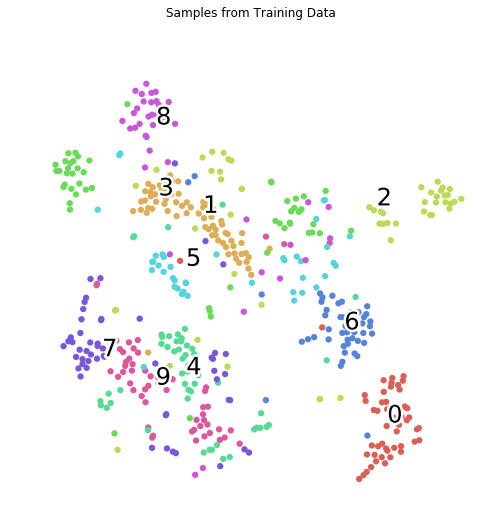

In [0]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, train_Y[:512], "Samples from Training Data")

In [0]:
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE

l = np.array(lbl)
l[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [0]:
preds_trans = TSNE().fit_transform(preds)

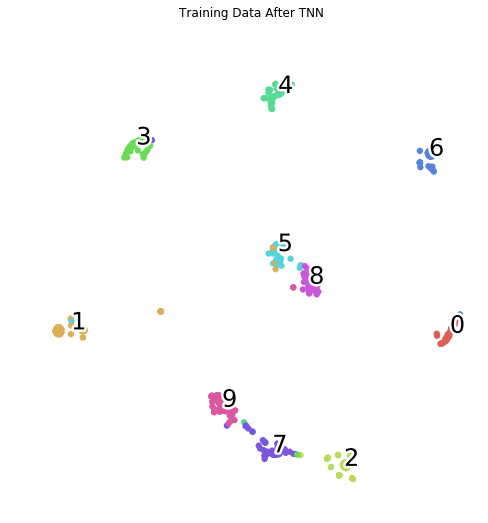

In [0]:
scatter(preds_trans, train_Y[:512], "Training Data After TNN")

In [0]:
preds_df = pd.DataFrame(np.concatenate((preds_trans, l[:, None]), axis=1), columns=['x','y','labels'])

In [0]:
preds_df.head()

,x,y,labels
0,-1.646187,4.600009,5.0
1,29.978218,-7.271741,0.0
2,1.266596,32.423031,4.0
3,-41.041939,-5.710828,1.0
4,-12.677921,-17.887129,9.0


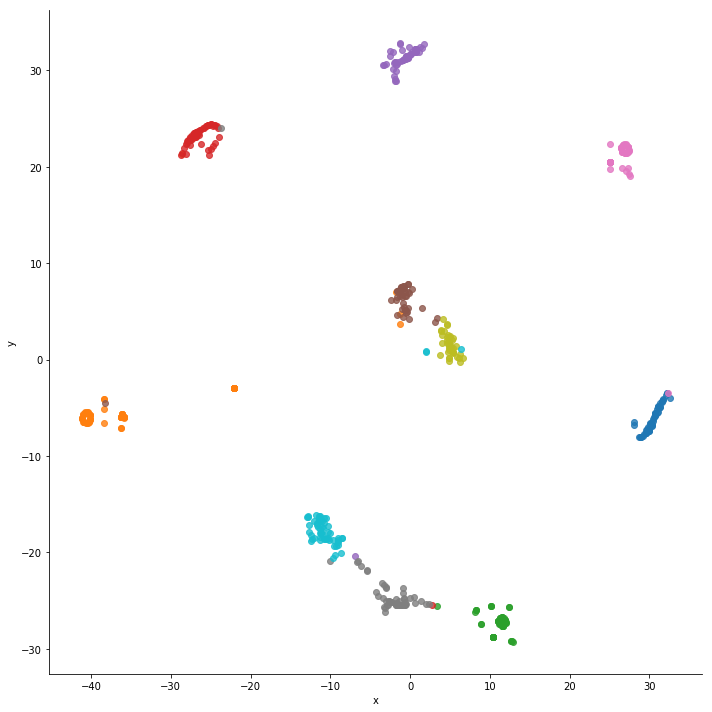

In [0]:
sns.lmplot('x', 'y', data=preds_df, hue='labels', fit_reg=False, legend=False, height=10)
plt.grid(visible=False)